In [2]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import io
from tqdm import tqdm

In [4]:
import sys
print(sys.executable)
! /apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin/python -m pip install --user datasets
! /apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin/python -m pip install --user ipykernel
! /apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin/python -m ipykernel install --user --name=myenv --display-name "Python 3.11 (myenv)"

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin/python
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Installed kernelspec myenv in /home/aub5uy/.local/share/jupyter/kernels/myenv


In [5]:
from datasets import load_dataset

ds = load_dataset("DamarJati/Face-Mask-Detection")

In [6]:
ds = ds['train']
#print(ds['train'].cache_files)

In [7]:
df = ds.to_pandas()
print(df.head())
print(df.info())

                                               image  label
0  {'bytes': None, 'path': 'zip://Test/WithMask/1...      0
1  {'bytes': None, 'path': 'zip://Test/WithMask/1...      0
2  {'bytes': None, 'path': 'zip://Test/WithMask/1...      0
3  {'bytes': None, 'path': 'zip://Test/WithMask/1...      0
4  {'bytes': None, 'path': 'zip://Test/WithMask/1...      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11792 entries, 0 to 11791
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11792 non-null  object
 1   label   11792 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 184.4+ KB
None


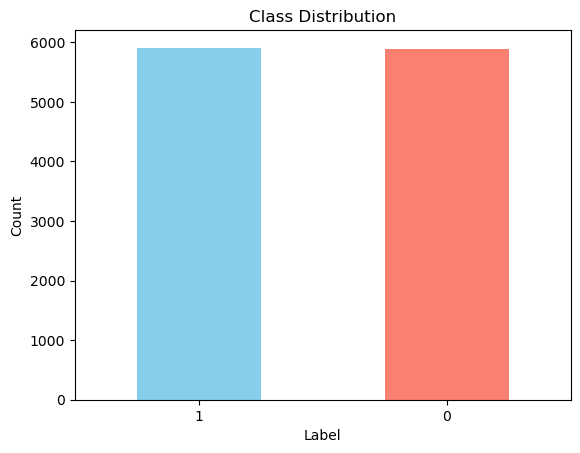

In [8]:
# Class distribution
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

Processing images: 100%|██████████| 11792/11792 [14:32<00:00, 13.52image/s]


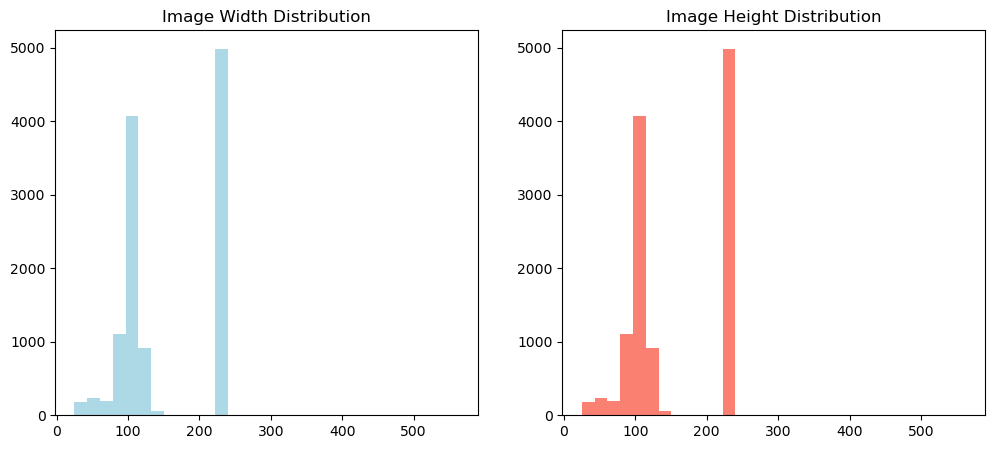

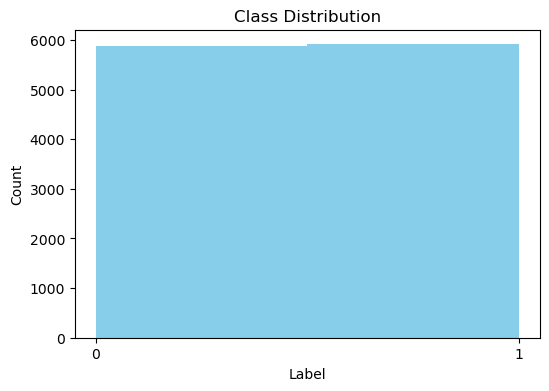

In [9]:
# Prepare lists to store dimensions and labels for EDA
image_widths = []
image_heights = []
labels = []

# Use tqdm to show the progress bar while iterating over the dataset
for item in tqdm(ds, desc="Processing images", unit="image"):
    # Access the PIL image and label
    img = item['image']  # Already a PIL Image
    label = item['label']

    # Collect dimensions and label
    image_widths.append(img.width)
    image_heights.append(img.height)
    labels.append(label)

# Plot histograms of widths and heights
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(image_widths, bins=30, color='lightblue')
axs[0].set_title("Image Width Distribution")
axs[1].hist(image_heights, bins=30, color='salmon')
axs[1].set_title("Image Height Distribution")
plt.show()

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.hist(labels, bins=len(set(labels)), color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(range(len(set(labels))))
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd



2024-11-28 18:32:02.973073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 18:32:04.092265: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-28 18:32:04.334780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732836724.638221  651140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732836724.748582  651140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 18:32:05.372981: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [9]:
import numpy as np

# Constants
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Prepare lists for images and labels
images = []
labels = []

# Process the dataset
for item in tqdm(ds, desc="Processing images", unit="image"):
    img = item['image']  # PIL Image object
    label = item['label']
    
    # Resize and normalize the image
    img = img.resize(IMG_SIZE)  # Resize using PIL
    img = np.array(img).astype('float32') / 255.0  # Convert to NumPy array and normalize
    images.append(img)
    labels.append(label)

# Create a DataFrame for splitting
df = pd.DataFrame({'image': images, 'label': labels})

# Split data into training, validation, and test sets (80-10-10 split)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

# Function to prepare datasets
def prepare_dataset(df, batch_size):
    # Stack images and create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((np.stack(df['image'].values), df['label'].values))
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and testing datasets
train_dataset = prepare_dataset(train_df, BATCH_SIZE)
val_dataset = prepare_dataset(val_df, BATCH_SIZE)
test_dataset = prepare_dataset(test_df, BATCH_SIZE)

Processing images:  62%|██████▏   | 7263/11792 [16:19<13:34,  5.56image/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Processing images: 100%|██████████| 11792/11792 [26:26<00:00,  7.43image/s]
W0000 00:00:1732838338.895156  651140 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
# Model Architecture: ResNet50 with transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Additional dense layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("Freeze base model layers:")

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)

print("\n\nUnfreezing base model layers:")

# Unfreeze base model layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Re-compile the model for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_finetune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=callbacks
)

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

Freeze base model layers:
Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 137s 439ms/step - accuracy: 0.6061 - loss: 0.6546 - val_accuracy: 0.6667 - val_loss: 0.5970
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 130s 437ms/step - accuracy: 0.6983 - loss: 0.5791 - val_accuracy: 0.7922 - val_loss: 0.5179
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 127s 429ms/step - accuracy: 0.7506 - loss: 0.5180 - val_accuracy: 0.8244 - val_loss: 0.4482
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 126s 425ms/step - accuracy: 0.8137 - loss: 0.4395 - val_accuracy: 0.8507 - val_loss: 0.4016
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 126s 424ms/step - accuracy: 0.8407 - loss: 0.3911 - val_accuracy: 0.8677 - val_loss: 0.3561
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 130s 438ms/step - accuracy: 0.8691 - loss: 0.3398 - val_accuracy: 0.8193 - val_loss: 0.4332
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 127s 428ms/step - accuracy: 0.8699 - loss: 0.3286 - val_accuracy: 0.8575 - val_loss: 0.3215
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 126s 426ms

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# Step 1: Predict probabilities on the test dataset
y_true = []
y_pred_prob = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Ground truth
    y_pred_prob.extend(model.predict(images).flatten())  # Predicted probabilities

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Step 2: Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5

# Step 3: Metrics for "Mask Present" (class 0)
# Confusion Matrix
cm = confusion_matrix(1-y_true, 1-y_pred)
tn, fp, fn, tp = cm.ravel()  # Extract TN, FP, FN, TP

# F1 Score for "Mask Present"
f1_mask = f1_score(y_true, y_pred, pos_label=0)

# Positive Predictive Value (PPV) for "Mask Present"
ppv_mask = precision_score(y_true, y_pred, pos_label=0)

# Miss Rate for "Mask Present" (FN / (TP + FN))
miss_rate_mask = fn / (fn + tp) if (fn + tp) > 0 else 0

# AUC-ROC
auc_mask = roc_auc_score(y_true == 0, 1-y_pred_prob)  # Focus on "Mask Present" (class 0)

# Print Metrics
print("Confusion Matrix:\n", cm)
print("F1 Score (Mask Present):", f1_mask)
print("Positive Predictive Value (PPV - Mask Present):", ppv_mask)
print("Miss Rate (Mask Present):", miss_rate_mask)
print("AUC-ROC (Mask Present):", auc_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2024-11-28 20:21:00.721485: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
